In [1]:
# pip install pandas yfinance

## Key Metrics for Evaluating Dividend Stocks

1. **Dividend Yield**
   - **Definition**: Measures the annual dividend payment as a percentage of the stock’s price.
   - **What to Look For**: A higher yield can be attractive, but ensure it’s sustainable and not excessively high due to a falling stock price.

2. **Dividend Payout Ratio**
   - **Definition**: The percentage of earnings paid out as dividends.
   - **Calculation**: 
     \[
     \text{Payout Ratio} = \frac{\text{Dividends Per Share}}{\text{Earnings Per Share}} \times 100
     \]
   - **What to Look For**: A lower ratio indicates a company retains more earnings for growth and stability. A high payout ratio might be risky if earnings fluctuate.

3. **Dividend Growth Rate**
   - **Definition**: The annualized percentage growth rate of dividends over a period.
   - **What to Look For**: Consistent and steady growth in dividends suggests a reliable and stable company.

4. **Dividend Stability**
   - **Definition**: Consistency in paying dividends over time.
   - **What to Look For**: Look for companies with a history of paying dividends through various economic conditions. Companies that have consistently paid dividends for many years are often considered more reliable.

5. **Free Cash Flow**
   - **Definition**: Cash generated by the company after accounting for capital expenditures.
   - **Calculation**: 
     \[
     \text{Free Cash Flow} = \text{Operating Cash Flow} - \text{Capital Expenditures}
     \]
   - **What to Look For**: Positive free cash flow is crucial as it indicates the company has enough cash to cover dividend payments and fund growth.

6. **Earnings Growth**
   - **Definition**: The rate at which a company’s earnings are increasing over time.
   - **What to Look For**: Strong earnings growth can support higher future dividends and indicate overall business health.

7. **Return on Equity (ROE)**
   - **Definition**: Measures a company’s profitability relative to shareholders' equity.
   - **Calculation**: 
     \[
     \text{ROE} = \frac{\text{Net Income}}{\text{Shareholders' Equity}} \times 100
     \]
   - **What to Look For**: A higher ROE indicates effective management and a potentially profitable investment.

8. **Debt-to-Equity Ratio**
   - **Definition**: Compares a company’s total liabilities to its shareholders' equity.
   - **Calculation**: 
     \[
     \text{Debt-to-Equity Ratio} = \frac{\text{Total Liabilities}}{\text{Shareholders' Equity}}
     \]
   - **What to Look For**: A lower ratio indicates lower financial risk. High debt levels can put pressure on dividends, especially during economic downturns.

9. **Interest Coverage Ratio**
   - **Definition**: Measures a company’s ability to pay interest on its debt.
   - **Calculation**: 
     \[
     \text{Interest Coverage Ratio} = \frac{\text{Earnings Before Interest and Taxes (EBIT)}}{\text{Interest Expense}}
     \]
   - **What to Look For**: A higher ratio suggests the company can easily meet its interest obligations, which is beneficial for maintaining dividends.

10. **Dividend Aristocrats and Dividend Kings**
    - **Definition**: Companies with a long history of increasing dividends.
    - **What to Look For**: Dividend Aristocrats have increased dividends for at least 25 consecutive years, and Dividend Kings have done so for at least 50 years.

11. **Market Conditions and Company Outlook**
    - **Definition**: Evaluate the company’s market position, industry conditions, and future growth prospects.
    - **What to Look For**: Understand the broader economic environment and industry trends that could impact the company's ability to maintain or grow its dividend.

12. **Historical Performance and Valuation**
    - **Definition**: Assess historical dividend payments and stock performance.
    - **What to Look For**: Ensure that past performance aligns with your investment goals and that the stock is reasonably valued compared to its historical averages.


In [2]:
import yfinance as yf
import logging
from typing import List, Dict

class DividendStockPortfolio:
    def __init__(self, wig_analysis: 'WIGCompanyAnalysis', available_cash: float) -> None:
        self.wig_analysis = wig_analysis
        self.available_cash = available_cash
        self.prices = {}
        self.portfolio = {}
        self.selected_tickers = []

    def fetch_current_prices(self) -> None:
        logging.info('Fetching current prices for selected tickers')
        for ticker in self.selected_tickers:
            try:
                stock = yf.Ticker(ticker)
                self.prices[ticker] = stock.history(period="1d")['Close'].iloc[-1]
            except Exception as e:
                logging.error('Error fetching price for %s: %s', ticker, e)
        logging.info('Current prices: %s', self.prices)

    def select_tickers_based_on_scenario(self, scenario_key: str) -> None:
        # Get the filtered tickers from the WIGCompanyAnalysis based on the scenario_key
        scenarios = self.wig_analysis.plot_data()
        if scenario_key not in scenarios:
            raise ValueError(f"Scenario key '{scenario_key}' not found in the WIGCompanyAnalysis results.")
        self.selected_tickers = scenarios[scenario_key]
        logging.info('Selected tickers for optimization based on %s: %s', scenario_key, self.selected_tickers)

    def optimize_portfolio(self) -> None:
        logging.info('Optimizing portfolio with available cash: %.2f', self.available_cash)
        if not self.selected_tickers:
            logging.warning('No tickers selected for optimization.')
            return

        self.fetch_current_prices()
        
        remaining_cash = self.available_cash

        # Divide the cash equally among the selected tickers
        cash_per_ticker = remaining_cash / len(self.selected_tickers)
        logging.info('Cash allocated per ticker: %.2f', cash_per_ticker)

        for ticker in self.selected_tickers:
            price = self.prices.get(ticker)
            if price and price > 0:
                # Calculate the maximum number of shares we can buy for this ticker within allocated cash
                max_shares = int(cash_per_ticker // price)
                if max_shares > 0:
                    self.portfolio[ticker] = max_shares
                    spent_cash = max_shares * price
                    remaining_cash -= spent_cash
                    logging.info('Bought %d shares of %s at %.2f each. Remaining cash: %.2f', max_shares, ticker, price, remaining_cash)
                else:
                    logging.info('Not enough cash to buy any shares of %s at %.2f each.', ticker, price)
            else:
                logging.info('No valid price available for %s.', ticker)

        logging.info('Optimized Portfolio: %s', self.portfolio)
        logging.info('Remaining cash after optimization: %.2f', remaining_cash)

    def get_portfolio(self) -> Dict[str, int]:
        return self.portfolio

    def get_remaining_cash(self) -> float:
        return self.available_cash - sum(self.portfolio.get(ticker, 0) * self.prices.get(ticker, 0) for ticker in self.portfolio)


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging
from typing import List, Dict

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class WIGCompanyAnalysis:
    def __init__(self, tickers: List[str], palette_name: str = "pastel") -> None:
        self.tickers = tickers
        self.palette_name = palette_name
        self.dividend_yields_df = pd.DataFrame()
        self.metrics_df = pd.DataFrame()
        self.data_fetch_date = datetime.now().strftime('%Y-%m-%d')
    
    def fetch_data(self) -> None:
        logging.info('Fetching data for tickers: %s', self.tickers)
        for ticker in self.tickers:
            try:
                stock = yf.Ticker(ticker)
                self._process_dividend_data(stock, ticker)
                self._process_metrics_data(stock, ticker)
            except Exception as e:
                logging.error('Error fetching data for %s: %s', ticker, e)

    def _process_dividend_data(self, stock: yf.Ticker, ticker: str) -> None:
        # Get the historical dividend data
        dividends = stock.dividends.reset_index()
        dividends['Ex-Dividend Date'] = dividends['Date']
        
        # Get historical stock prices
        prices = stock.history(period="max")['Close'].reset_index()
        
        # Merge dividends with the price data
        dividends = pd.merge(dividends, prices, left_on='Ex-Dividend Date', right_on='Date', how='left')
        
        # Calculate dividend yield in percentage
        dividends['Dividend Yield (%)'] = (dividends['Dividends'] / dividends['Close']) * 100
        dividends['Ticker'] = ticker
        
        # Select relevant columns
        dividends = dividends[
            [
                'Ticker',
                'Ex-Dividend Date',
                'Dividends',
                'Close',
                'Dividend Yield (%)',
            ]
        ]
        
        # Append to the main DataFrame
        self.dividend_yields_df = pd.concat([self.dividend_yields_df, dividends])

    def _process_metrics_data(self, stock: yf.Ticker, ticker: str) -> None:
        # Fetch additional financial data
        info = stock.info
        
        # Calculate metrics and store in DataFrame
        metrics = {
            'Ticker': ticker,
            'Dividend Yield (%)': info.get('dividendYield', float('nan')) * 100,
            'Payout Ratio (%)': info.get('payoutRatio', float('nan')) * 100,
            'Free Cash Flow (Billion $)': info.get('freeCashflow', float('nan')) / 1e9,
            'Earnings Growth (%)': info.get('earningsGrowth', float('nan')) * 100,
            'ROE (%)': info.get('returnOnEquity', float('nan')) * 100,
            'Debt-to-Equity Ratio': info.get('debtToEquity', float('nan')),
            'Interest Coverage Ratio': info.get('interestCoverage', float('nan')),
        }
        
        self.metrics_df = pd.concat([self.metrics_df, pd.DataFrame([metrics])], ignore_index=True)

    def plot_data(self) -> Dict[str, set]:
        logging.info('Plotting data')
        sns.set(style="whitegrid")
    
        # Create subplots with one column and six rows
        fig, axes = plt.subplots(6, 1, figsize=(12, 24), sharex=False)
    
        # Get the color palette based on the selected palette name
        palette = sns.color_palette(self.palette_name, len(self.tickers))
        color_map = dict(zip(self.tickers, palette))
        
        # Sort metrics_df by Dividend Yield in descending order for the bar chart
        sorted_metrics_df = self.metrics_df.sort_values(by='Dividend Yield (%)', ascending=False)
    
        # Plot Dividend Yield (%) over time for each ticker
        sns.lineplot(ax=axes[0], data=self.dividend_yields_df, x="Ex-Dividend Date", y="Dividend Yield (%)", hue="Ticker", palette=color_map, marker="o", legend=False)
        axes[0].set_title("Dividend Yield (%) Over Time")
        axes[0].set_ylabel("Dividend Yield (%)")
        axes[0].axhline(y=5, color='r', linestyle='--', label='5% Dividend Yield')
        axes[0].axhline(y=10, color='b', linestyle='--', label='10% Dividend Yield')
        axes[0].axhline(y=15, color='g', linestyle='--', label='15% Dividend Yield')
        axes[0].grid(True)
        axes[0].set_xlabel(f"Data fetched on: {self.data_fetch_date}")
    
        # Annotate data points with rounded dividend yield percentages
        for _, row in self.dividend_yields_df.iterrows():
            if pd.notna(row['Dividend Yield (%)']):
                axes[0].annotate(f"{round(row['Dividend Yield (%)'])}%",
                                    (row['Ex-Dividend Date'], row['Dividend Yield (%)']),
                                    textcoords="offset points",
                                    xytext=(0, 5),
                                    ha='center')
    
        # Plot Dividends over time for each ticker
        sns.lineplot(ax=axes[1], data=self.dividend_yields_df, x="Ex-Dividend Date", y="Dividends", hue="Ticker", palette=color_map, marker="o", legend=False)
        axes[1].set_title("Dividends Over Time")
        axes[1].set_ylabel("Dividends")
        axes[1].grid(True)
        axes[1].set_xlabel(f"Data fetched on: {self.data_fetch_date}")
    
        # Annotate data points with rounded dividend amounts
        for _, row in self.dividend_yields_df.iterrows():
            if pd.notna(row['Dividends']):
                axes[1].annotate(f"{round(row['Dividends'])}",
                                    (row['Ex-Dividend Date'], row['Dividends']),
                                    textcoords="offset points",
                                    xytext=(0, 5),
                                    ha='center')
    
        # Plot Dividend Yield (%) by Ticker
        sns.barplot(ax=axes[2], data=sorted_metrics_df, x='Ticker', y='Dividend Yield (%)', hue='Ticker', palette=color_map, legend=False)
        axes[2].set_title("Dividend Yield (%) by Ticker")
        axes[2].set_ylabel("Dividend Yield (%)")
        axes[2].set_xlabel(f"Data fetched on: {self.data_fetch_date}")
        axes[2].grid(True)
    
        # Add labels to bars with rounded percentages
        for container in axes[2].containers:
            axes[2].bar_label(container, fmt='%d%%')
    
        # Plot Payout Ratio by Ticker
        sns.barplot(ax=axes[3], data=sorted_metrics_df, x='Ticker', y='Payout Ratio (%)', hue='Ticker', palette=color_map, legend=False)
        axes[3].set_title("Payout Ratio (%) by Ticker")
        axes[3].set_ylabel("Payout Ratio (%)")
        axes[3].set_xlabel(f"Data fetched on: {self.data_fetch_date}")
        axes[3].grid(True)
    
        # Add labels to bars with rounded percentages
        for container in axes[3].containers:
            axes[3].bar_label(container, fmt='%d%%')
    
        # Plot Free Cash Flow by Ticker
        sns.barplot(ax=axes[4], data=sorted_metrics_df, x='Ticker', y='Free Cash Flow (Billion $)', hue='Ticker', palette=color_map, legend=False)
        axes[4].set_title("Free Cash Flow (Billion $) by Ticker")
        axes[4].set_ylabel("Free Cash Flow (Billion $)")
        axes[4].set_xlabel(f"Data fetched on: {self.data_fetch_date}")
        axes[4].grid(True)
    
        # Add labels to bars with rounded numbers
        for container in axes[4].containers:
            axes[4].bar_label(container, fmt='%d')
    
        # Plot Earnings Growth by Ticker
        sns.barplot(ax=axes[5], data=sorted_metrics_df, x='Ticker', y='Earnings Growth (%)', hue='Ticker', palette=color_map, legend=False)
        axes[5].set_title("Earnings Growth (%) by Ticker")
        axes[5].set_ylabel("Earnings Growth (%)")
        axes[5].set_xlabel(f"Data fetched on: {self.data_fetch_date}")
        axes[5].grid(True)
    
        # Add labels to bars with rounded percentages
        for container in axes[5].containers:
            axes[5].bar_label(container, fmt='%d%%')
    
        # Rotate x-axis labels for better readability
        for ax in axes:
            plt.setp(ax.get_xticklabels(), rotation=45)
    
        # Add a single legend to the first subplot for tickers
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1), title="Ticker")
    
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
        plt.show()

        # Print tickers based on scenarios
        scenarios = {
            'Dividend Yield above 5% and Positive Earnings Growth': self.metrics_df[
                (self.metrics_df['Dividend Yield (%)'] > 5) & 
                (self.metrics_df['Earnings Growth (%)'] > 0)
            ]['Ticker'].tolist(),
            'Dividend Yield above 10% and Positive Earnings Growth': self.metrics_df[
                (self.metrics_df['Dividend Yield (%)'] > 10) & 
                (self.metrics_df['Earnings Growth (%)'] > 0)
            ]['Ticker'].tolist(),
            'Dividend Yield above 15% and Positive Earnings Growth': self.metrics_df[
                (self.metrics_df['Dividend Yield (%)'] > 15) & 
                (self.metrics_df['Earnings Growth (%)'] > 0)
            ]['Ticker'].tolist()
        }

        for scenario, tickers in scenarios.items():
            print(f"\n{scenario}:")
            print(set(tickers))

        return scenarios


In [4]:
# Usage example:
tickers = [
        
        # 2024-08-17
        
        # WIG20
        # https://stooq.pl/q/i/?s=wig20
        "SPL.WA",  # Santander Bank Polska SA (SPL) - DY: 13.1
        "PEO.WA",  # Bank Polska Kasa Opieki SA (PEO) - DY: 12.0
        "PKN.WA",  # ORLEN SA (PKN) - DY: 8.6
        "KTY.WA",  # Grupa Kęty SA (KTY) - DY: 7.7
        "PKO.WA",  # Powszechna Kasa Oszczędności Bank Polski SA (PKO) - DY: 6.8
        "BDX.WA",  # Budimex SA (BDX) - DY: 5.9
        "OPL.WA",  # Orange Polska SA (OPL) - DY: 5.9
        "PZU.WA",  # Powszechny Zakład Ubezpieczeń SA (PZU) - DY: 5.0
        
        
        # mWIG40
        # https://stooq.pl/q/i/?s=mwig40
        "ING.WA",  # ING Bank Śląski SA (ING) - DY: 12.0
        "BHW.WA",  # Bank Handlowy w Warszawie SA (BHW) - DY: 11.9
        "LWB.WA",  # Lubelski Węgiel Bogdanka SA (LWB) - DY: 10.0
        "DVL.WA",  # Develia SA (DVL) - DY: 8.8
        "XTB.WA",  # X-Trade Brokers SA (XTB) - DY: 7.5
        "DOM.WA",  # Bank Polska Kasa Opieki SA (PEO) - DY: 7.3
        "GPW.WA",  # Giełda Papierów Wartościowych w Warszawie SA (GPW) - DY: 7.0
        "ASB.WA",  # ASBISc Enterprises PLC (ASB) - DY: 5.7
        "ATC.WA",  # Arctic Paper SA (ATC) - DY: 5.5
        "RBW.WA",  # Rainbow Tours SA (RBW) - DY: 5.3
        "MBR.WA",  # Mo-BRUK SA (MBR) - DY: 4.6
        "TXT.WA",  # TEXT SA (TXT) - DY: 3.9
        "GPP.WA",  # Grupa Pracuj SA (GPP) - DY: 3.6
        "ACP.WA",  # Asseco Poland SA (ACP) - DY: 3.5
        
        # sWIG80
        # https://stooq.pl/q/i/?s=swig80
        "STX.WA",  # Stalexport Autostrady SA (STX) - DY: 16.9
        "WTN.WA",  # Wittchen SA (WTN) - DY: 12.4
        "1AT.WA",  # Atal SA (1AT) - DY: 11.9
        "OTS.WA",  # OT Logistics SA (OTS) - DY: 11.8
        "VOT.WA",  # Votum SA (VOT) - DY: 8.4
        "ELT.WA",  # Elektrotim SA (ELT) - DY: 8.0
        "PCR.WA",  # PCC Rokita SA (PCR) - DY: 7.5
        "MGT.WA",  # Mangata Holding SA (MGT) - DY: 7.5
        "PLW.WA",  # PlayWay SA (PLW) - DY: 7.4
        "AST.WA",  # Astarta Holding NV (AST) - DY: 7.2
        "ENT.WA",  # Enter Air SA (ENT) - DY: 7.2
        "BRS.WA",  # Boryszew SA (BRS) - DY: 7.2
        "TOR.WA",  # Torpol SA (TOR) - DY: 6.5
        "SNK.WA",  # Sanok Rubber Company SA (SNK) - DY: 5.9
        "INK.WA",  # Instal Kraków SA (INK) - DY: 5.8
        "MUR.WA",  # Murapol SA (MUR) - DY: 5.8
        "OPN.WA",  # Oponeo.pl SA (OPN) - DY: 5.5
        "DCR.WA",  # Decora SA (DCR) - DY: 5.5
        "VRG.WA",  # VRG SA (VRG) - DY: 5.4
        "WWL.WA",  # Wawel SA (WWL) - DY: 5.2
    ]

2024-08-17 15:49:13,075 - INFO - Fetching data for tickers: ['KTY.WA', 'PKO.WA', 'BDX.WA', 'PZU.WA', 'DVL.WA', 'XTB.WA', 'GPW.WA', 'RBW.WA', 'GPP.WA', 'ACP.WA', '1AT.WA', 'ELT.WA', 'PLW.WA', 'INK.WA', 'DCR.WA', 'WWL.WA']
2024-08-17 15:49:20,788 - INFO - Plotting data


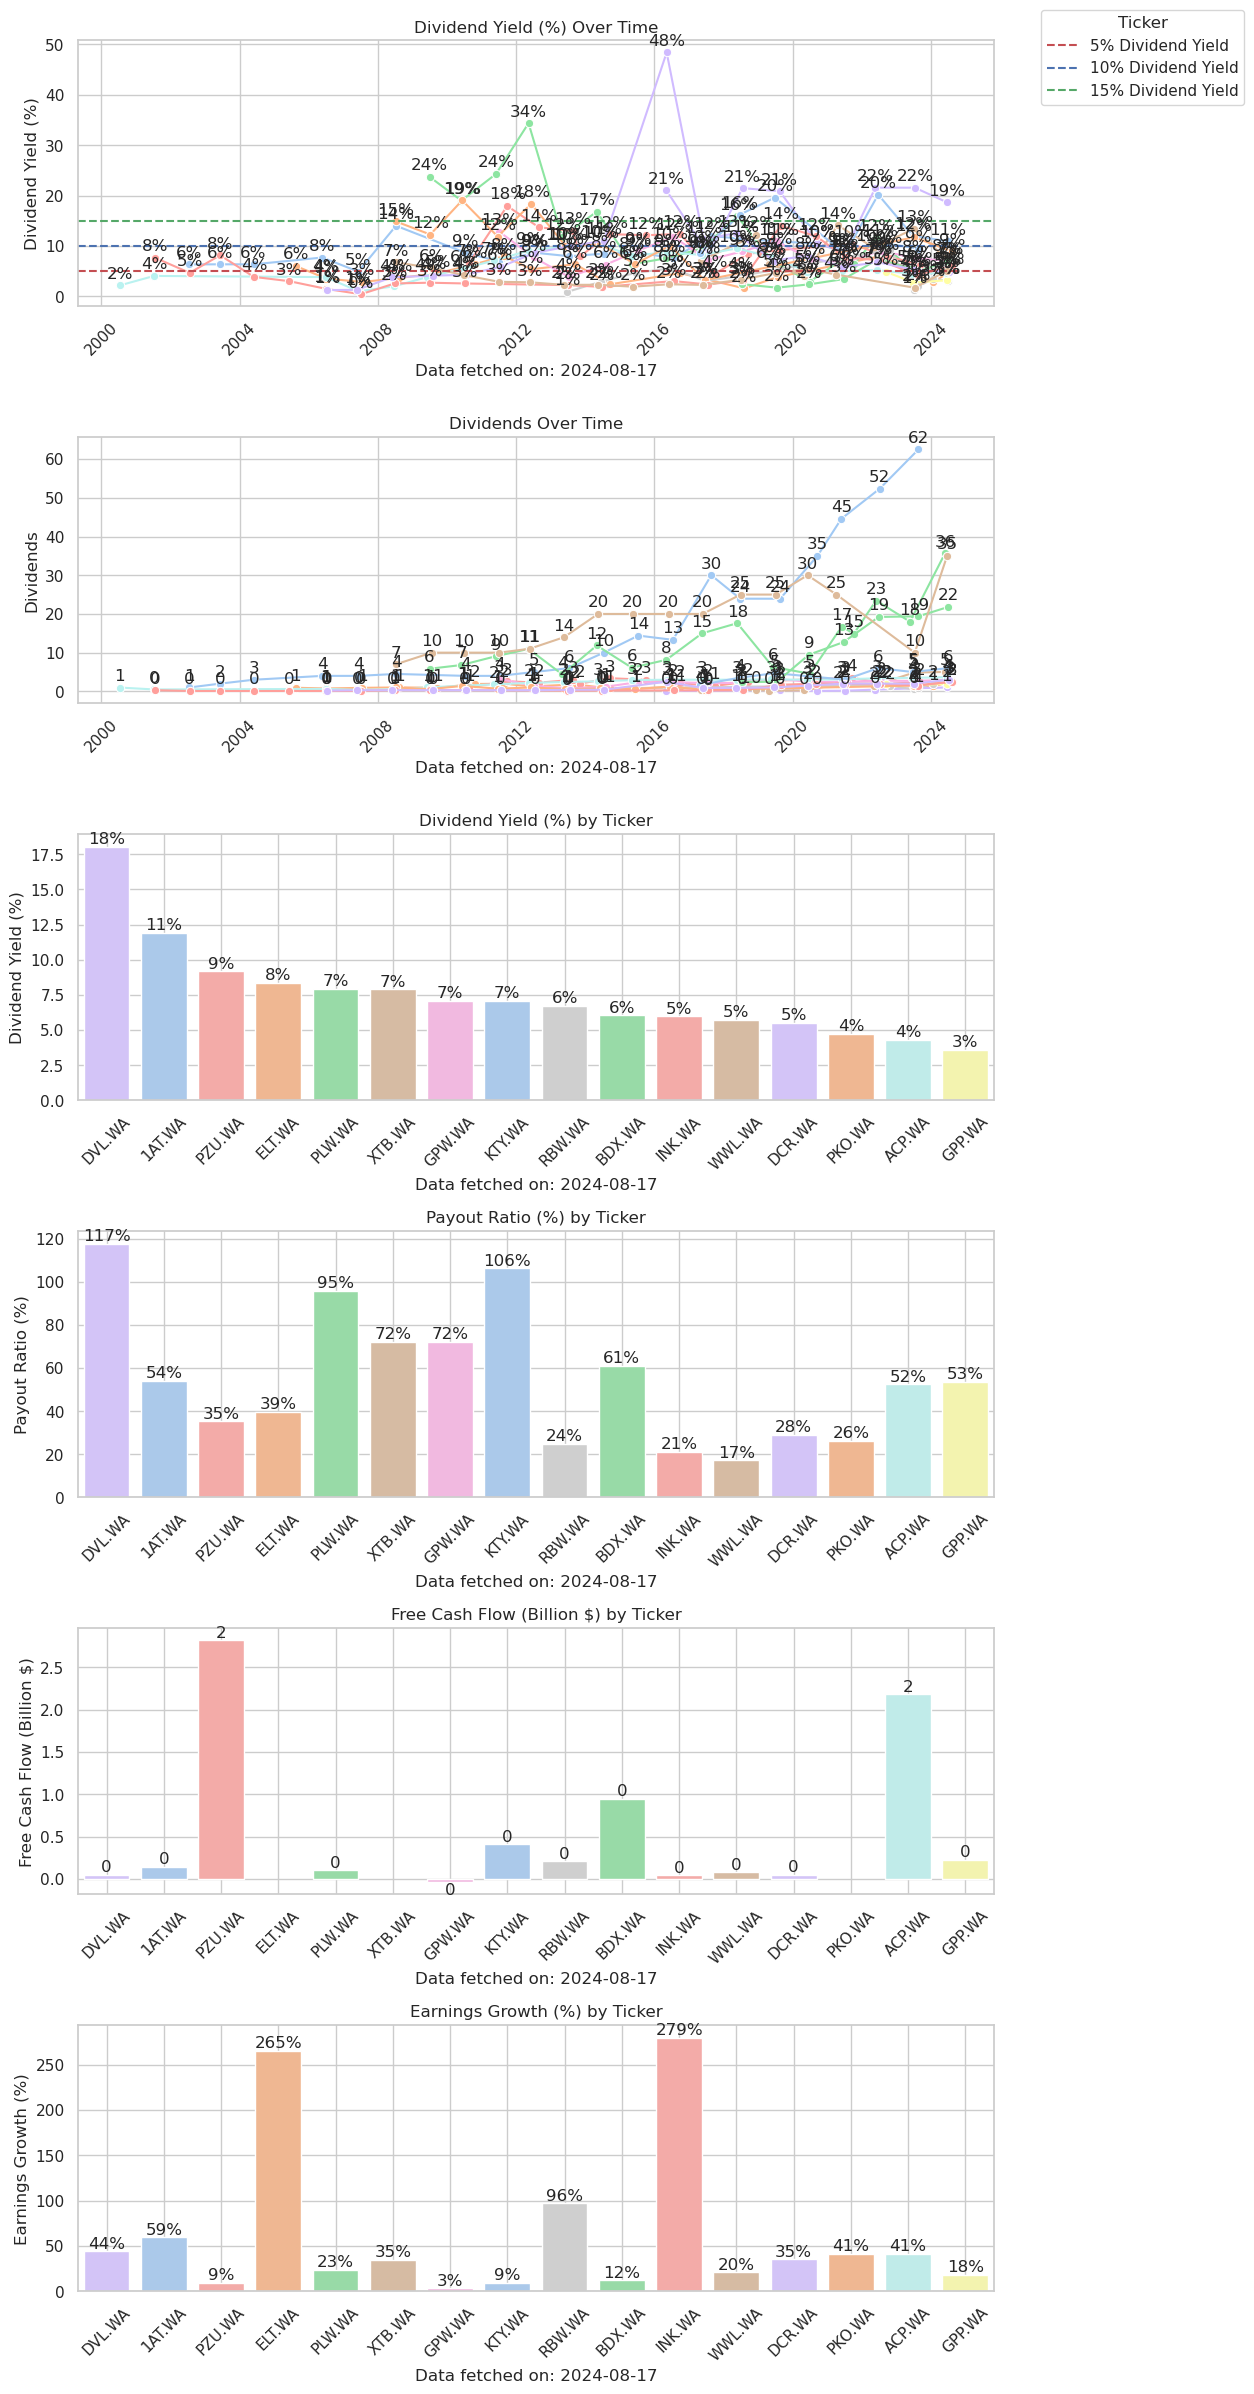

2024-08-17 15:49:25,584 - INFO - Plotting data



Dividend Yield above 5% and Positive Earnings Growth:
{'1AT.WA', 'ELT.WA', 'INK.WA', 'XTB.WA', 'BDX.WA', 'PLW.WA', 'DCR.WA', 'PZU.WA', 'GPW.WA', 'RBW.WA', 'WWL.WA', 'DVL.WA', 'KTY.WA'}

Dividend Yield above 10% and Positive Earnings Growth:
{'DVL.WA', '1AT.WA'}

Dividend Yield above 15% and Positive Earnings Growth:
{'DVL.WA'}

--- Optimizing Portfolio for Scenario: Dividend Yield above 5% and Positive Earnings Growth ---


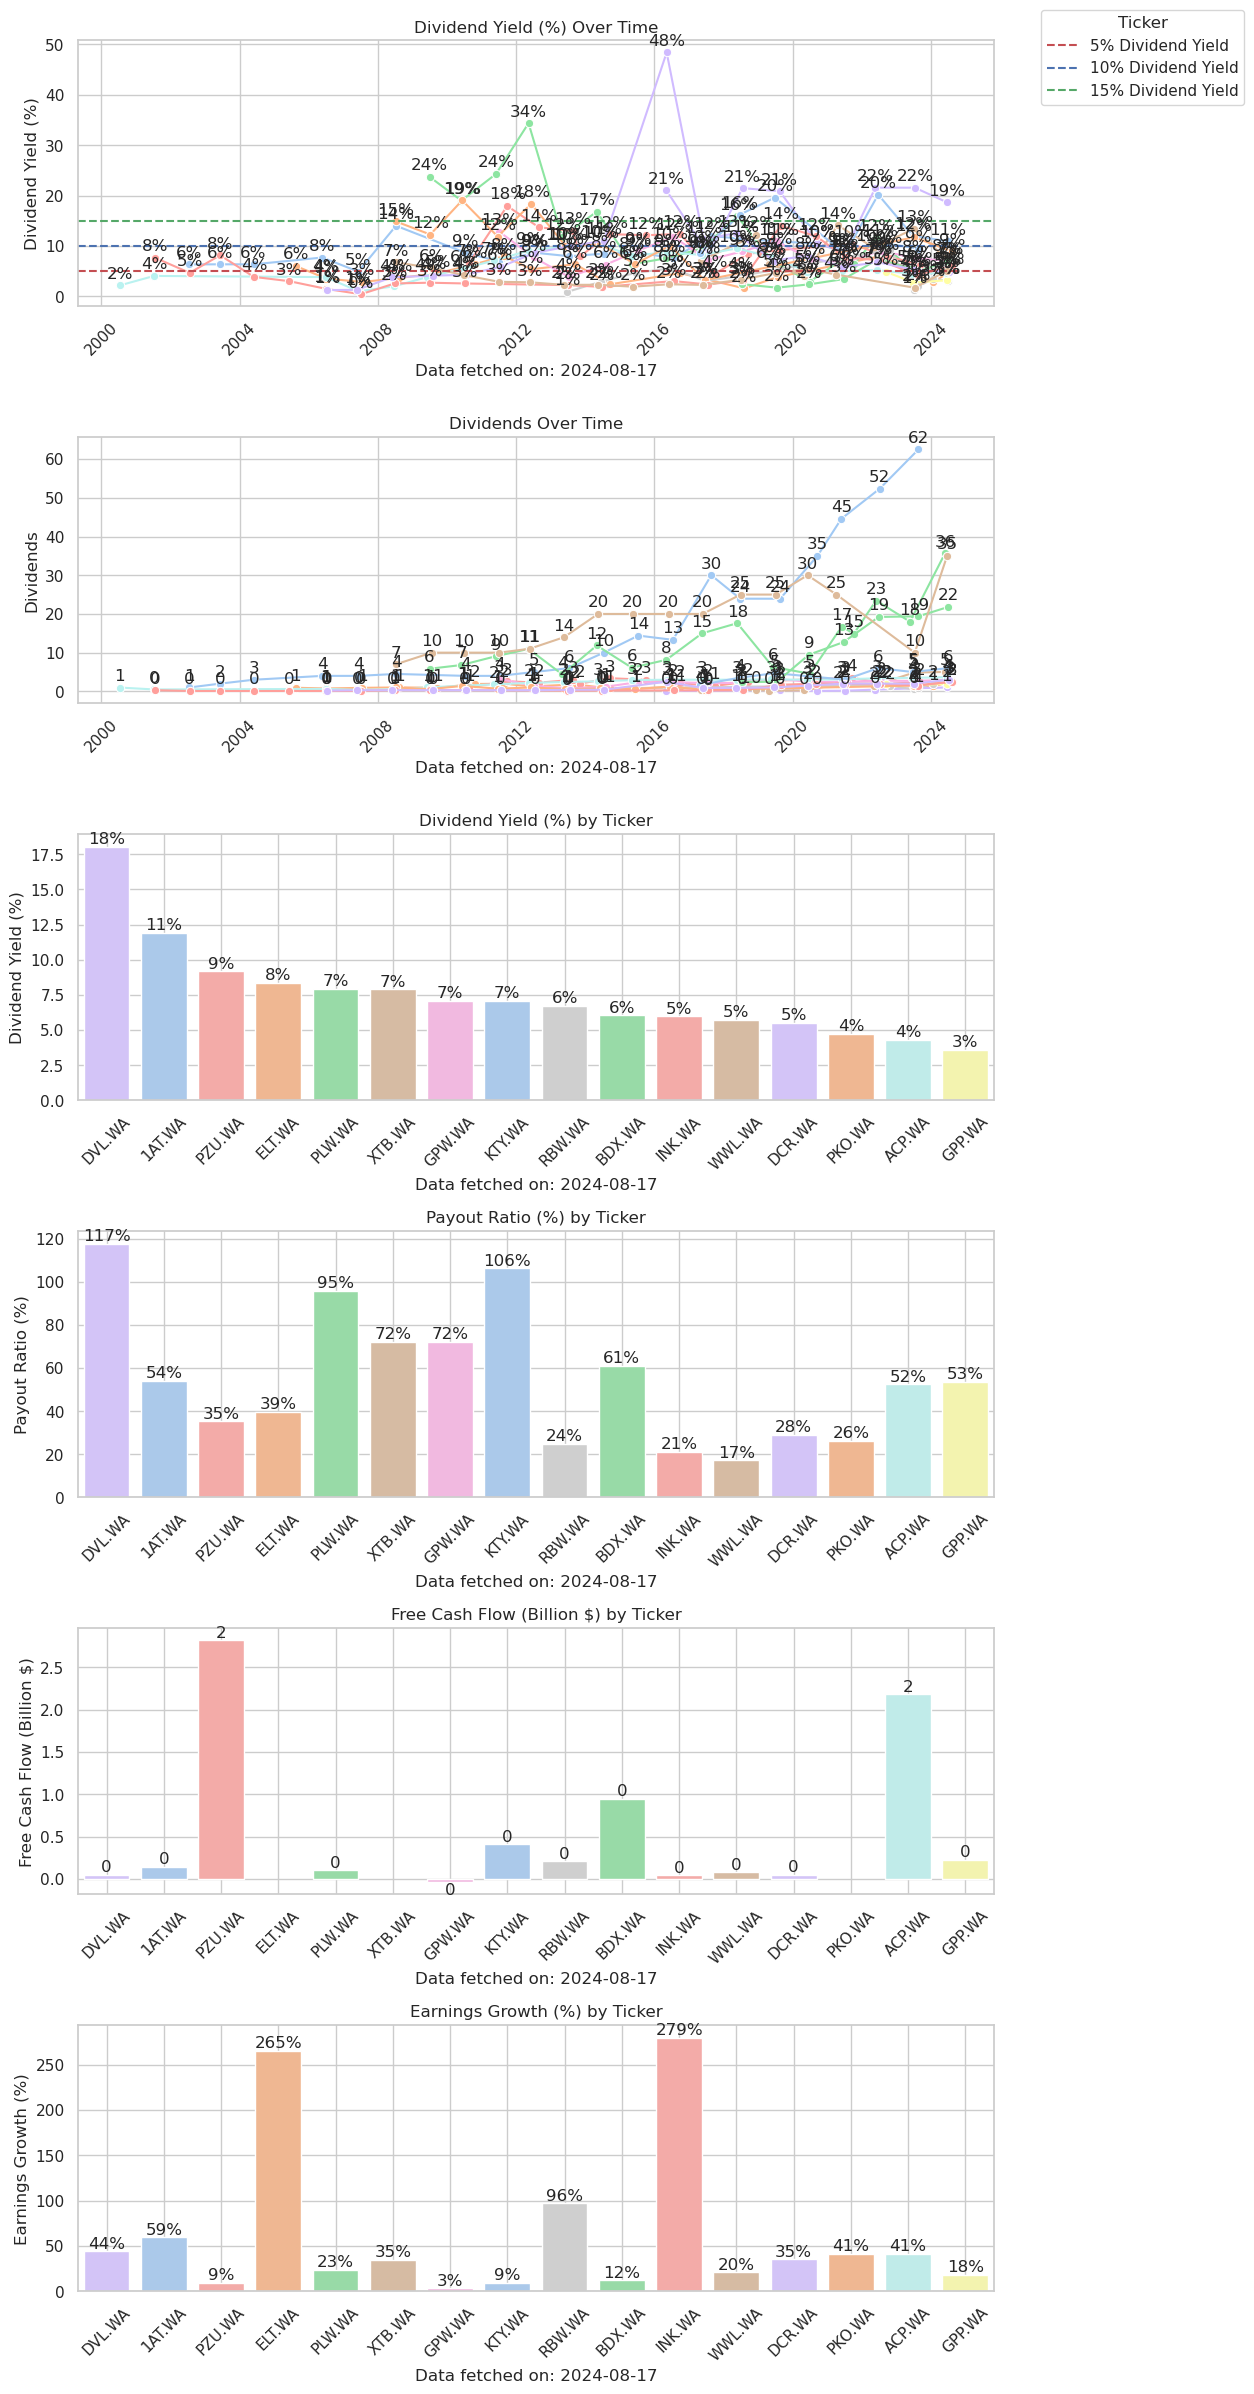

2024-08-17 15:49:30,382 - INFO - Selected tickers for optimization based on Dividend Yield above 5% and Positive Earnings Growth: ['KTY.WA', 'BDX.WA', 'PZU.WA', 'DVL.WA', 'XTB.WA', 'GPW.WA', 'RBW.WA', '1AT.WA', 'ELT.WA', 'PLW.WA', 'INK.WA', 'DCR.WA', 'WWL.WA']
2024-08-17 15:49:30,383 - INFO - Optimizing portfolio with available cash: 100000.00
2024-08-17 15:49:30,384 - INFO - Fetching current prices for selected tickers



Dividend Yield above 5% and Positive Earnings Growth:
{'1AT.WA', 'ELT.WA', 'INK.WA', 'XTB.WA', 'BDX.WA', 'PLW.WA', 'DCR.WA', 'PZU.WA', 'GPW.WA', 'RBW.WA', 'WWL.WA', 'DVL.WA', 'KTY.WA'}

Dividend Yield above 10% and Positive Earnings Growth:
{'DVL.WA', '1AT.WA'}

Dividend Yield above 15% and Positive Earnings Growth:
{'DVL.WA'}


2024-08-17 15:49:31,768 - INFO - Current prices: {'KTY.WA': 805.0, 'BDX.WA': 603.5, 'PZU.WA': 48.2400016784668, 'DVL.WA': 5.690000057220459, 'XTB.WA': 66.5999984741211, 'GPW.WA': 42.95000076293945, 'RBW.WA': 103.0, '1AT.WA': 50.400001525878906, 'ELT.WA': 31.25, 'PLW.WA': 294.5, 'INK.WA': 42.900001525878906, 'DCR.WA': 54.400001525878906, 'WWL.WA': 578.0}
2024-08-17 15:49:31,769 - INFO - Cash allocated per ticker: 7692.31
2024-08-17 15:49:31,769 - INFO - Bought 9 shares of KTY.WA at 805.00 each. Remaining cash: 92755.00
2024-08-17 15:49:31,770 - INFO - Bought 12 shares of BDX.WA at 603.50 each. Remaining cash: 85513.00
2024-08-17 15:49:31,770 - INFO - Bought 159 shares of PZU.WA at 48.24 each. Remaining cash: 77842.84
2024-08-17 15:49:31,771 - INFO - Bought 1351 shares of DVL.WA at 5.69 each. Remaining cash: 70155.65
2024-08-17 15:49:31,771 - INFO - Bought 115 shares of XTB.WA at 66.60 each. Remaining cash: 62496.65
2024-08-17 15:49:31,772 - INFO - Bought 179 shares of GPW.WA at 42.95 ea

Optimized Portfolio for Dividend Yield above 5% and Positive Earnings Growth: {'KTY.WA': 9, 'BDX.WA': 12, 'PZU.WA': 159, 'DVL.WA': 1351, 'XTB.WA': 115, 'GPW.WA': 179, 'RBW.WA': 74, '1AT.WA': 152, 'ELT.WA': 246, 'PLW.WA': 26, 'INK.WA': 179, 'DCR.WA': 141, 'WWL.WA': 13}
Remaining Cash for Dividend Yield above 5% and Positive Earnings Growth: 1317.80

-----------------------------

--- Optimizing Portfolio for Scenario: Dividend Yield above 10% and Positive Earnings Growth ---


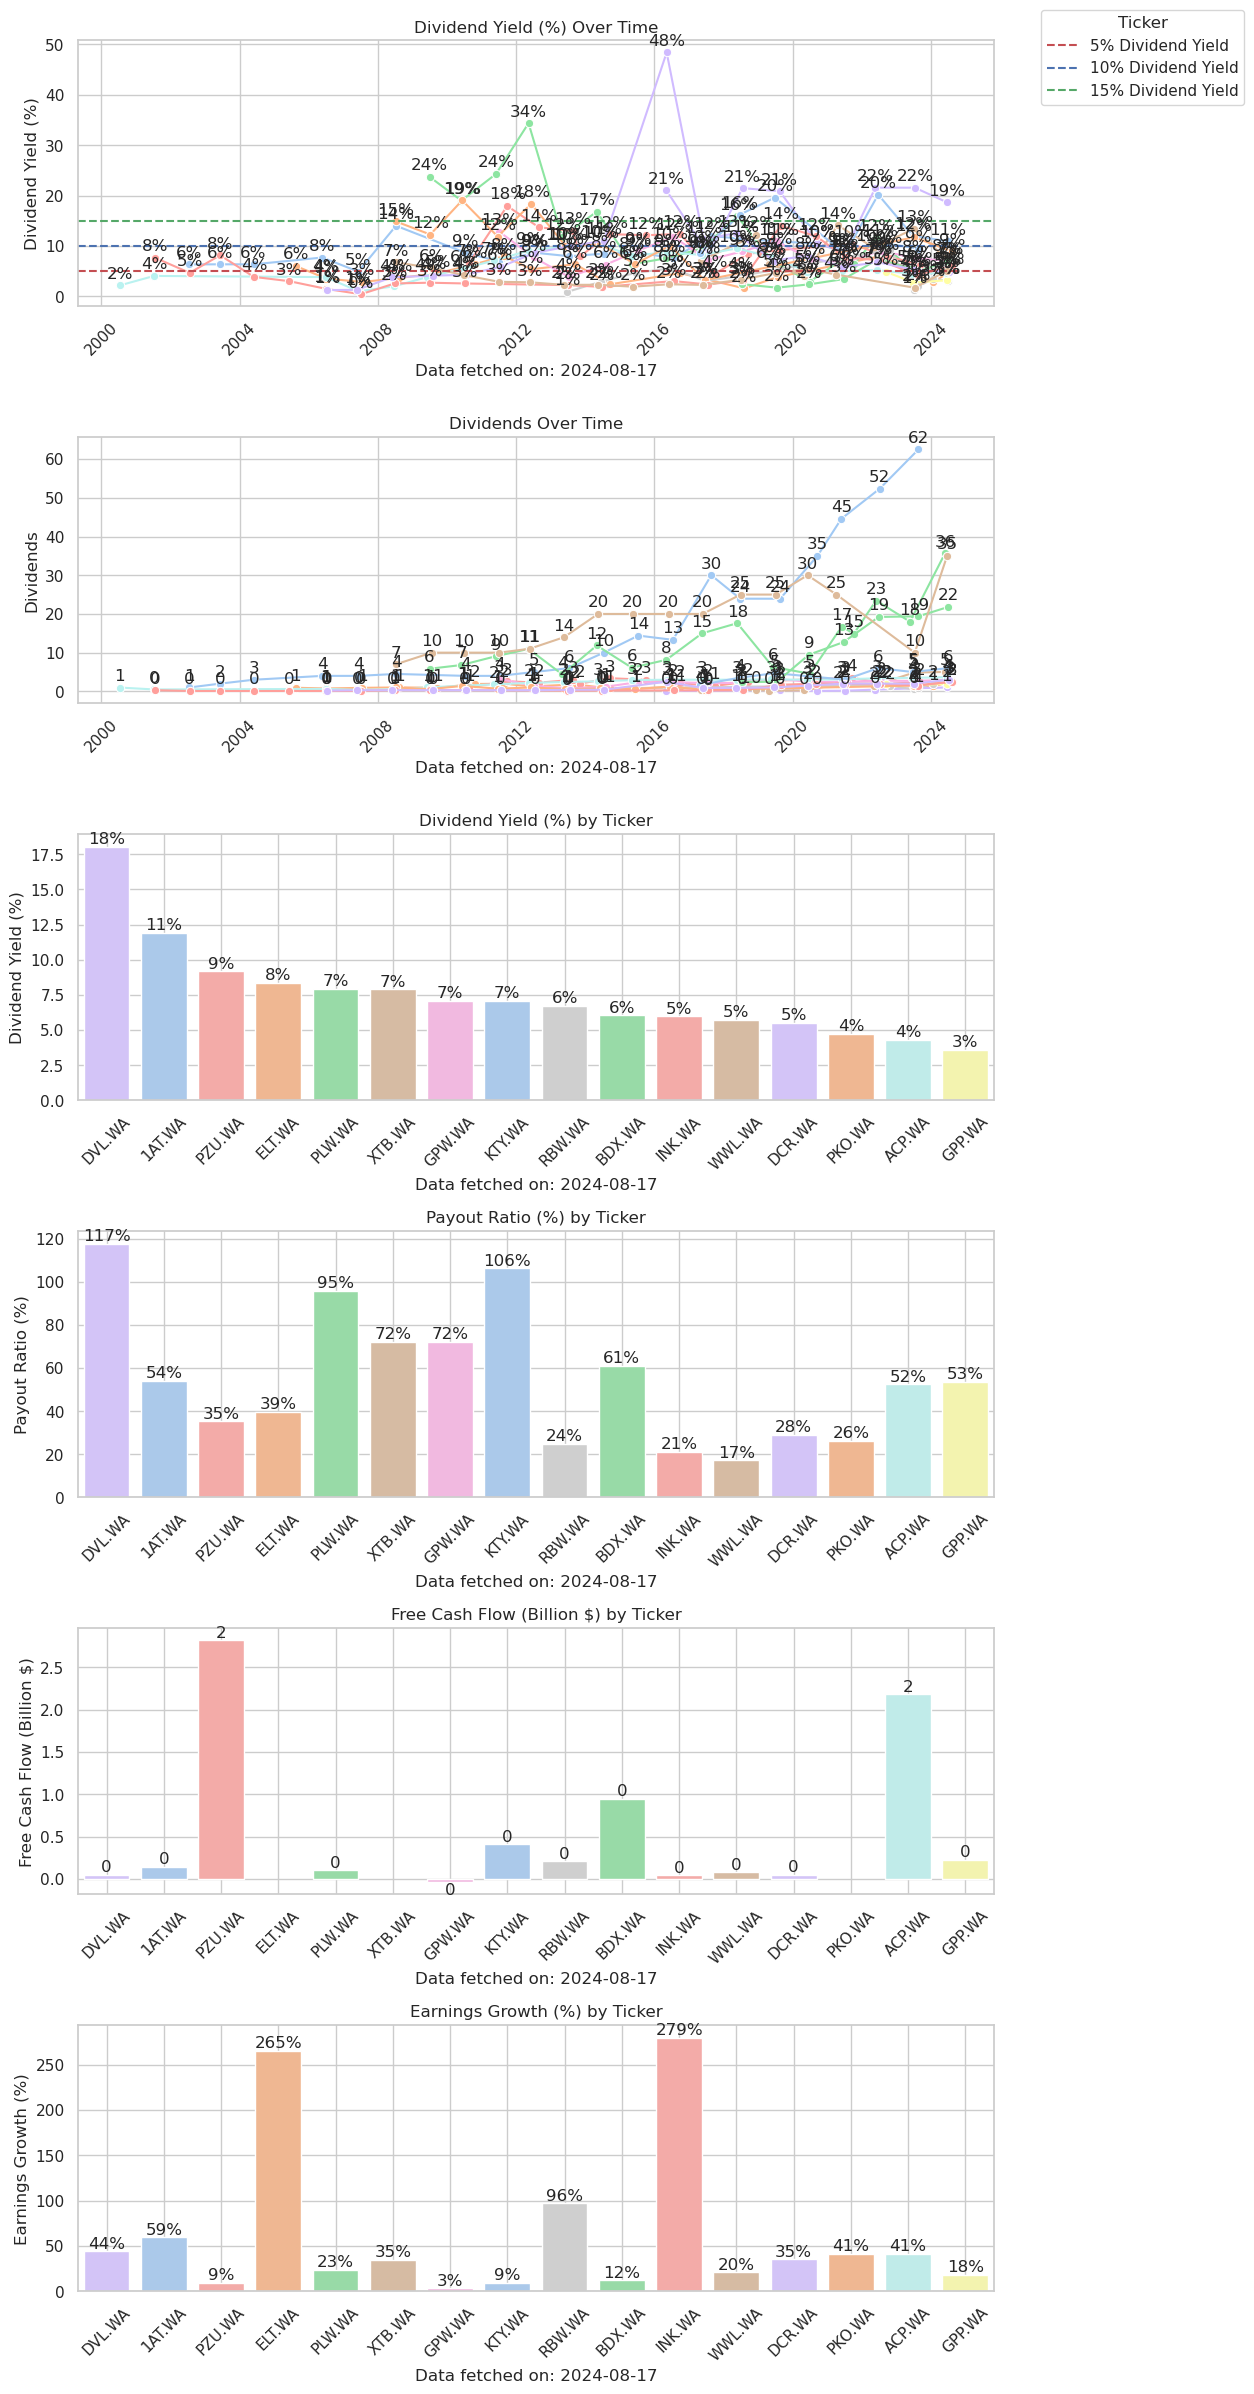

2024-08-17 15:49:36,729 - INFO - Selected tickers for optimization based on Dividend Yield above 10% and Positive Earnings Growth: ['DVL.WA', '1AT.WA']
2024-08-17 15:49:36,730 - INFO - Optimizing portfolio with available cash: 100000.00
2024-08-17 15:49:36,731 - INFO - Fetching current prices for selected tickers
2024-08-17 15:49:36,818 - INFO - Current prices: {'KTY.WA': 805.0, 'BDX.WA': 603.5, 'PZU.WA': 48.2400016784668, 'DVL.WA': 5.690000057220459, 'XTB.WA': 66.5999984741211, 'GPW.WA': 42.95000076293945, 'RBW.WA': 103.0, '1AT.WA': 50.400001525878906, 'ELT.WA': 31.25, 'PLW.WA': 294.5, 'INK.WA': 42.900001525878906, 'DCR.WA': 54.400001525878906, 'WWL.WA': 578.0}
2024-08-17 15:49:36,819 - INFO - Cash allocated per ticker: 50000.00
2024-08-17 15:49:36,819 - INFO - Bought 8787 shares of DVL.WA at 5.69 each. Remaining cash: 50001.97
2024-08-17 15:49:36,820 - INFO - Bought 992 shares of 1AT.WA at 50.40 each. Remaining cash: 5.17
2024-08-17 15:49:36,821 - INFO - Optimized Portfolio: {'KTY.WA


Dividend Yield above 5% and Positive Earnings Growth:
{'1AT.WA', 'ELT.WA', 'INK.WA', 'XTB.WA', 'BDX.WA', 'PLW.WA', 'DCR.WA', 'PZU.WA', 'GPW.WA', 'RBW.WA', 'WWL.WA', 'DVL.WA', 'KTY.WA'}

Dividend Yield above 10% and Positive Earnings Growth:
{'DVL.WA', '1AT.WA'}

Dividend Yield above 15% and Positive Earnings Growth:
{'DVL.WA'}
Optimized Portfolio for Dividend Yield above 10% and Positive Earnings Growth: {'KTY.WA': 9, 'BDX.WA': 12, 'PZU.WA': 159, 'DVL.WA': 8787, 'XTB.WA': 115, 'GPW.WA': 179, 'RBW.WA': 74, '1AT.WA': 992, 'ELT.WA': 246, 'PLW.WA': 26, 'INK.WA': 179, 'DCR.WA': 141, 'WWL.WA': 13}
Remaining Cash for Dividend Yield above 10% and Positive Earnings Growth: -83329.04

-----------------------------

--- Optimizing Portfolio for Scenario: Dividend Yield above 15% and Positive Earnings Growth ---


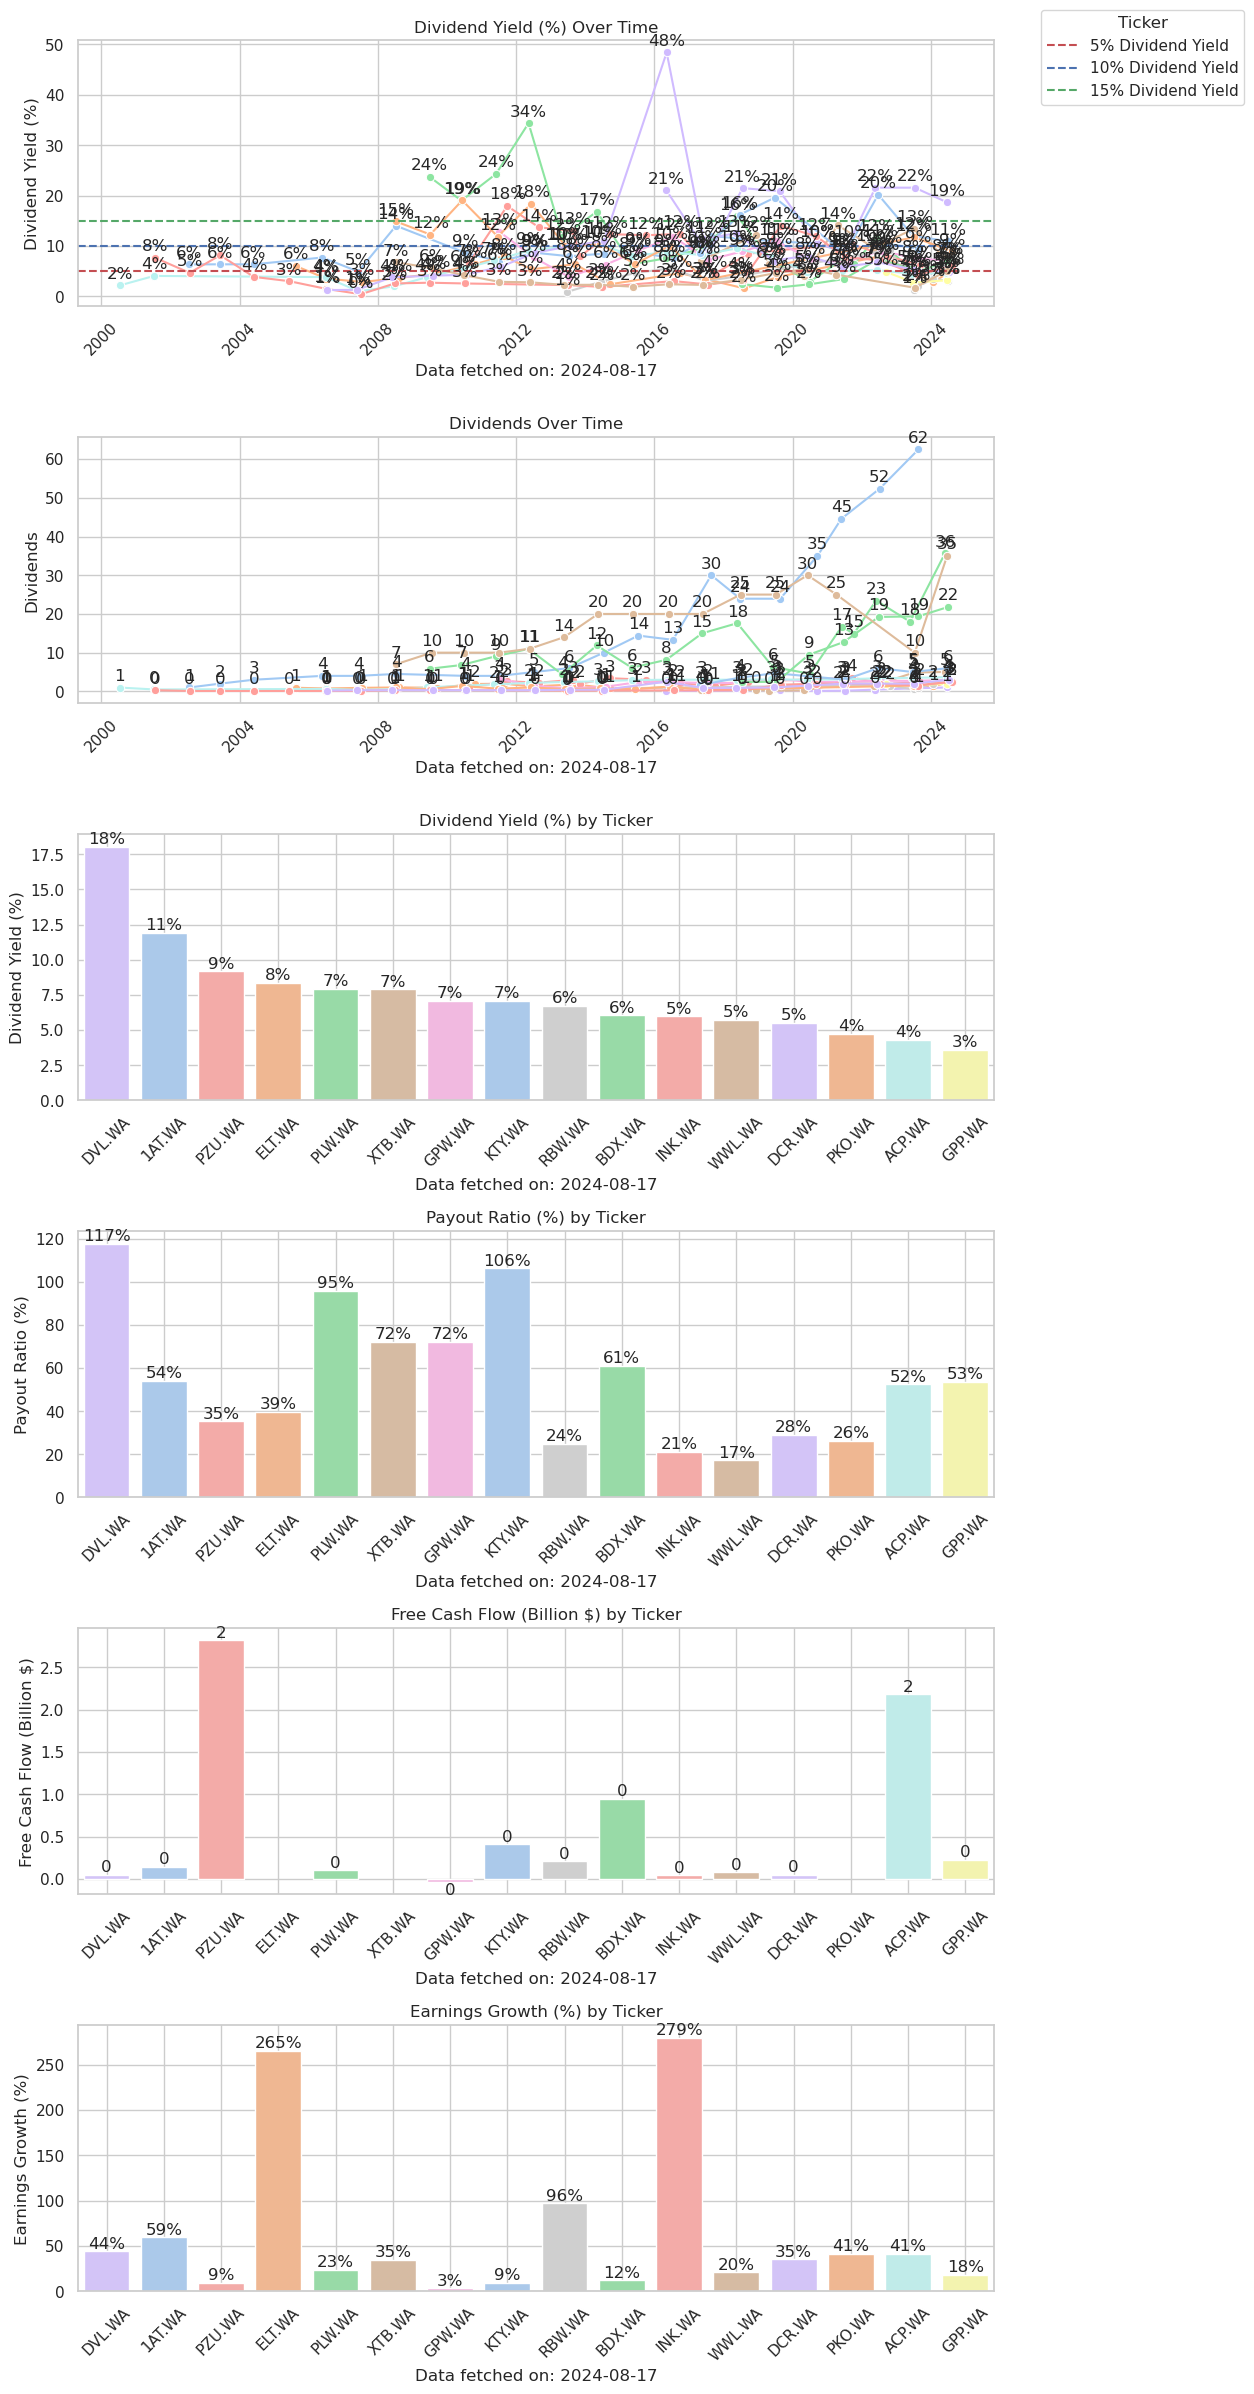

2024-08-17 15:49:41,769 - INFO - Selected tickers for optimization based on Dividend Yield above 15% and Positive Earnings Growth: ['DVL.WA']
2024-08-17 15:49:41,770 - INFO - Optimizing portfolio with available cash: 100000.00
2024-08-17 15:49:41,770 - INFO - Fetching current prices for selected tickers
2024-08-17 15:49:41,891 - INFO - Current prices: {'KTY.WA': 805.0, 'BDX.WA': 603.5, 'PZU.WA': 48.2400016784668, 'DVL.WA': 5.690000057220459, 'XTB.WA': 66.5999984741211, 'GPW.WA': 42.95000076293945, 'RBW.WA': 103.0, '1AT.WA': 50.400001525878906, 'ELT.WA': 31.25, 'PLW.WA': 294.5, 'INK.WA': 42.900001525878906, 'DCR.WA': 54.400001525878906, 'WWL.WA': 578.0}
2024-08-17 15:49:41,891 - INFO - Cash allocated per ticker: 100000.00
2024-08-17 15:49:41,892 - INFO - Bought 17574 shares of DVL.WA at 5.69 each. Remaining cash: 3.94
2024-08-17 15:49:41,892 - INFO - Optimized Portfolio: {'KTY.WA': 9, 'BDX.WA': 12, 'PZU.WA': 159, 'DVL.WA': 17574, 'XTB.WA': 115, 'GPW.WA': 179, 'RBW.WA': 74, '1AT.WA': 992


Dividend Yield above 5% and Positive Earnings Growth:
{'1AT.WA', 'ELT.WA', 'INK.WA', 'XTB.WA', 'BDX.WA', 'PLW.WA', 'DCR.WA', 'PZU.WA', 'GPW.WA', 'RBW.WA', 'WWL.WA', 'DVL.WA', 'KTY.WA'}

Dividend Yield above 10% and Positive Earnings Growth:
{'DVL.WA', '1AT.WA'}

Dividend Yield above 15% and Positive Earnings Growth:
{'DVL.WA'}
Optimized Portfolio for Dividend Yield above 15% and Positive Earnings Growth: {'KTY.WA': 9, 'BDX.WA': 12, 'PZU.WA': 159, 'DVL.WA': 17574, 'XTB.WA': 115, 'GPW.WA': 179, 'RBW.WA': 74, '1AT.WA': 992, 'ELT.WA': 246, 'PLW.WA': 26, 'INK.WA': 179, 'DCR.WA': 141, 'WWL.WA': 13}
Remaining Cash for Dividend Yield above 15% and Positive Earnings Growth: -133327.07

-----------------------------


In [5]:
import logging

# Ensure logging is configured
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define tickers
tickers = [
    'KTY.WA', 'PKO.WA', 'BDX.WA', 'PZU.WA', 'DVL.WA',
    'XTB.WA', 'GPW.WA', 'RBW.WA', 'GPP.WA', 'ACP.WA',
    '1AT.WA', 'ELT.WA', 'PLW.WA', 'INK.WA', 'DCR.WA',
    'WWL.WA'
]

# Initialize WIGCompanyAnalysis
wig_analysis = WIGCompanyAnalysis(tickers=tickers)

# Fetch data for analysis
wig_analysis.fetch_data()

# Plot data and get tickers for each scenario
scenarios = wig_analysis.plot_data()

# Define available cash
available_cash = 100000  # Example amount

# Initialize DividendStockPortfolio
portfolio = DividendStockPortfolio(wig_analysis=wig_analysis, available_cash=available_cash)

# Process each scenario
for scenario_key, tickers_list in scenarios.items():
    print(f"\n--- Optimizing Portfolio for Scenario: {scenario_key} ---")
    
    # Select tickers based on the scenario
    portfolio.select_tickers_based_on_scenario(scenario_key)
    
    # Optimize the portfolio
    portfolio.optimize_portfolio()
    
    # Retrieve and display the results
    optimized_portfolio = portfolio.get_portfolio()
    remaining_cash = portfolio.get_remaining_cash()
    
    print(f"Optimized Portfolio for {scenario_key}: {optimized_portfolio}")
    print(f"Remaining Cash for {scenario_key}: {remaining_cash:.2f}")
    
    print("\n-----------------------------")
